## Group Assignment
### Team Number: 05
### Team Member Names: Piero Camposeo, Sathun Suthakaran, Ishaan Bansal
### Team Strategy Chosen: SAFE

## Overview:

We want to generate an unusually "safe" short-term portfolio. Rather than maximize returns, we want to keep returns as close as possible to zero. The goal is to generate a portfolio, based on a random set of tickers, whose projected value over an arbitrary number of days is as close to its starting value as possible. Specifically, our code is made for a 5-day run-time of the portfolio, but the model used is viable for any short period of time (though it is often not preferred compared to other benchmarks such as a normal CAPM, and short-term assumptions are made).

The code is split into four sections:

1. DATA CLEANING
2. CHOOSING THE STOCKS
3. CREATING THE OPTIMAL PORTFOLIO
4. ANALYSIS AND SANITY / CORRECTNESS CHECKS

Data cleaning involves removing tickers that do not fit a certain criteria, chosen by the user.

Choosing the stocks involves picking the least volatile tickers, which we will utilize in our final portfolio.

Creating the portfolio involves generating randomly weighted portfolios, comprised of our tickers. The final portfolio will be that which has the expected return closest to 0. We will calculate expected return based on a <b>modified, Multi-Security Capital Asset Pricing Model</b> (below), whereby we assume the risk free rate to be zero (since this model should be used for a short time horizon, we expect the variation between the market and risk-free rate to be immaterial), and multiply the market's expected return by the sum of the products of each securities' respective weight and beta.

![Modified, Multi-Security CAPM](Pricing-Model-Image.png)

The code should output the final portfolio and share count to a .csv file.

Analysis and sanity checks involves visual representations to enhance comprehension, ensuring that the value of the portfolio is correct, as well as showing that the portfolio is indeed expected to return close to 0 over a short period of time.

Objective assumptions (As per assignment instructions):

- Fractional shares can be purchased
- There will be no transaction costs when buying stocks.
- Once the portfolio is set, it cannot be changed.
- Dividends will be ignored

## Why CAPM?

The Capital Asset Pricing Model (CAPM for short) gives the expected return for an asset relational to its risk with the market.

One of the primary assumptions we make when deriving the desired portfolio for a short term investment horizon is that <b>systematic risk will drive the majority of price volatility.</b> There are two reasons for this:

1. Since we choose a large amount of stocks to put in the portfolio, the portfolio will likely be diversified. This means less risk for a high portfolio correlation, or volatility based on certain unsystematic events.

2. Since we have a short term investment horizon, there is little time for unsystematic risk factors to push our returns away from the goal.

With this assumption in mind, we decided that the CAPM was the best pricing model to use for three reasons:

1. It is a tested and proven model

2. Including beta as a factor allows us to imply both correlation and risk into one variable

3. Including beta as a factor, by nature will bias the allocation of capital towards stocks who have a lower volatility (and therefore a lower beta)

Note some of the issues with other popular methods for generating this type of portfolio:

1. Picking the portfolio with the lowest volatility
- Doesn't consider correlation. It's possibe for the correlation between securities in this model may be high, therefore causing the direction of volatility to be stronger.

2. Picking the portfolio with the lowest espected return (by combining the averages of the returns for each security)
- Doesn't consider volatility heavily. IThe magnitude of volatility may be strong. For a short time-horizon, this can be bad.

In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import threading
import time
from queue import Queue
import random
from random import uniform

In [2]:
#Read in csv file of tickers
csv_file = "Tickers.csv"

# Make values into a list
tickers = pd.read_csv(csv_file)
ticker_list = tickers.iloc[:, 0].values.tolist()
ticker_list.insert(0, tickers.columns[0])

In [3]:
#Consumes desired amount of trading days within a month, a dataframe of days, a dstaframe of months, and a list of months that cooresponds to the months
#    on the dataframe, outputs the monthly dataframe with only months that have 'daycount' amount of trading days for that stock
#Note: Function will cover up to the last date. For example, the function will not produce October for a dataframe which ends on October 1st.
#   In our code, we simply passed a days dataframe that ends one month after the months dataframe does (*)
def df_with_valid_months(daycount, df_days, df_months, months):
    for month in range (len(months)):
        if len(df_days.filter(like = months[month], axis = 0)) < daycount:
            df_months.drop(df_months.index[month], axis = 0, inplace = True) #Drop any months with not enough trading days
            
    return(df_months)

#Consumes historical data for a stock, outputs average volume
def average_volume(df_hist):
    volume = df_hist['Volume'].dropna().values.tolist()
    vol_av = np.mean(volume)

    return(vol_av)


## 1. DATA CLEANING: 

This cell is where the data cleaning happens.

THE GOAL:

•	Ignore any tickers that do not reference a valid stock denominated in USD, i.e., only use US listed stocks.

•	Use only tickers that reference stocks which have an average monthly volume of at least 200,000 shares, as calculated based on the time interval of January 01, 2022 to October 31, 2022. A month is defined as a calendar month. We will drop any month that does not have at least 20 trading days.

THE PROCESS:

Firstly, we have chosen to implement multithreading, in order to speed up the process. The data cleaning is the most time-consuming code in the program to run (Due to the time it takes to send a request to the yfinance API). Due to this, we have two main functions (currency_check and volume_check), running on two seperate threads, c and v. These functions are defined recursively; If too many tickers are passed into the function (i.e a list of tickers that is longer than the 'max_length_lst' variable in each function), the function calls on a number of threads to run the function with smaller, sublists. When a small enough quantity of tickers is passed to the function, it will perform the criteria check for the tickers. Valid tickers get passed to the function's respective queue. Finally, the queue is cleared, and tickers that fit both criterion are outputted and saved as our tickers.

Note 1: Currency check generates more threads per application than volume_check because it takes significantly longer to run. This is also why its 'max_list_length' variable is smaller

Note 2: For the sake of comparison, when tested by our team:

- Unthreaded, non-recursive code takes ~13 minutes to run
- Multithreaded, non-recursive code takes ~5-10 minutes to run
- <b>Multithreaded, recursive code takes ~1 minute to run</b>

Note 3: 'max_length_lst' may need to be updates for larger lists of tickers

Our code checks each of the two criterion mentioned in the goal (one for each function), and helps to generate two lists. Each list contains tickers which reference stocks that have satisfied the criteria of the functions. As we want stocks that fit both criterion, our final list of (valid) tickers is the set intersection of the two lists which each function produces.


In [4]:
#dates for volume calculation, end date for valid months function (see (*))
vol_date_s = '2022-01-01'
vol_date_e = '2022-10-02'
endDForValidMonthsFunct = str((pd.to_datetime(vol_date_e) + relativedelta(months = 1)).strftime("%Y-%m-%d"))

#for df_with_valid_months function, creates a series of months from vol_date_s to vol_date_e
months = pd.date_range(vol_date_s, vol_date_e, freq='MS').strftime("%Y-%m").tolist()

#As outlined in assignment information
minimumMonthlyTradingDays = 20
minimum_volume = 200000
required_denomination = 'USD'

#Here we will put valid stocks that fit our criteria
tickers = []

currency_valid = []
volume_valid = []

#Queue variables to store tickers
queueC = Queue()
queueV = Queue()

#Consumes a list of tickers, used to check if they are denominated in 'required_denomination'.
def currency_check(ticker_list):
    max_length_lst = 5

    #When there are an appropriate number of tickers in ticker_list, the function performs currency_check
    if len(ticker_list) <= max_length_lst:

        #Retrieve financial currency from each ticker. If it is 'required_denomination', it is a valid ticker. Else, we don't care so we set it as nan
        for ticker in ticker_list:
            tick = yf.Ticker(ticker)
            try:
                currency = tick.info['currency']
            except:
                currency = 'nan'
        
            #Check criteria, add to list of valid tickers for currency
            if currency == required_denomination:
                #Pass our valid tickers to the QueueC (Queue Currency), so that they may be called on later
                queueC.put(ticker)

    #If there are too many tickers in ticker_lst, we run a recursive application of currency_check with five threads, with the arguments being one of
    #Five equal parts of ticker_list  
    else:
        ticker_split = np.array_split(ticker_list, 5)

        # Start five threads, add to list 
        threads = []
        for n in range(5):
            cSub = threading.Thread(target = currency_check, args = (ticker_split[n],))
            cSub.start()
            threads.append(cSub)

        # Wait for threads to finish.
        for t in threads:
            t.join()
 
#Consumes a list of tickers, used to check if they have an average monthly volume of 'minimum_volume' or more over each month with
#'minimumMonthlyTradingDays' or more trading days
def volume_check(ticker_list):
    max_length_lst = 20
    
    #When there are an appropriate number of tickers in ticker_list, the function performs currency_check
    if len(ticker_list) <= max_length_lst:

        #Retrieve mnthly average volume from each ticker, if it is greater than or equal to minimum_volume, it is a valid ticker. Else, we ignore it.
        for ticker in ticker_list:
            tick = yf.Ticker(ticker)
        
            try:
                #Check for Delisted ticker + Creating histories. If 'check' returns an error, the code continues. Without this try/except,
                #Error code for delisted stock appears twice
                tick_hist = tick.history(start = vol_date_s, end  = vol_date_e, interval = '1mo').dropna()
                check = tick_hist.iloc[0,0]
                #Custom dataframe for valid months check (daily, ending one month after monthly dataframe)
                tickHistForValidMonthsCheck = tick.history(start = vol_date_s, end  = endDForValidMonthsFunct, interval = '1d').dropna()
 
                #Dataframe with valid months only
                tickHistWithValidMonths = df_with_valid_months(minimumMonthlyTradingDays, tickHistForValidMonthsCheck, tick_hist, months)

                #Call on average_volume function to compute and average volume
                monthly_average_volume = 0 #Initialize this to 0 to prevent errors
                monthly_average_volume = average_volume(tickHistWithValidMonths)
        
                #Check criteria, add to list of valid tickers for volume
                if monthly_average_volume >= minimum_volume:
                    #Pass our valid tickers to the QueueV (Queue Volume), so that they may be called on later
                    queueV.put(ticker)
       
            except:
                pass

    #If there are too many tickers in ticker_lst, we run a recursive application of volume_check with two threads, with the arguments being one of
    #two equal parts of ticker_list    
    else:
        ticker_split = np.array_split(ticker_list, 2)

        # Start two threads, add to list 
        threads = []
        for n in range(2):
            vSub = threading.Thread(target = volume_check, args = (ticker_split[n],))
            vSub.start()
            threads.append(vSub)

        # Wait for all threads to finish.
        for t in threads:
            t.join()

#Creating threads for currency_check and volume_check function
c = threading.Thread(target = currency_check, args = (ticker_list,))
v = threading.Thread(target = volume_check, args = (ticker_list,))

#Start thread executions
c.start()
v.start()

#Wait for v to finish, grab all elements from queue
v.join()
while not queueV.empty():
    volume_valid.append(queueV.get())


#Wait for c to finish, grab all elements from queue
c.join()
while not queueC.empty():
    currency_valid.append(queueC.get())

#Valid tickers are the intersection of the two lists (Must have particular denomination and average monthly volume as outlined in assignment)
tickers = sorted([value for value in currency_valid if value in volume_valid])

print(f"\nValid Tickers: {tickers}")

- CELG: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted

Valid Tickers: ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


## 2. CHOOSING THE STOCKS:

The following cells are where we choose the stocks to be used for the final portfolio.

THE GOAL:

Since our overall goal is to have a portfolio which finishes as close to its starting value as possible, we naturally want a diversified and stable selection of stocks. With this in mind, we decided to choose as many stocks as allowed (so as to avoid unsystematic risk), with stocks chosen being the least volatile out of the available selection. Essentially, we want:

•	(if there are less than 25 tickers to choose from) every (valid) ticker available <b>OR</b> 25 tickers (maximum allowed as outlined in assignment information) comprised of:

•	The least volatile stocks available

    •	Note: Volatility, as we define it in this section, is represented by the standard deviation of daily returns (over a recent 5 month period, specifically)

THE PROCESS:

We will obtain closing data for each ticker, and calculate returns using the pct_change() function. Then, we will take the standard deviation of those returns and select the tickers with the lowest values.

The code below takes in a list of valid tickers and returns 2 DataFrames -- one containing the tickers and their closing prices, and one containing the tickers and their respective percent returns. 

We iterate through the list of tickers and retrieve the closing prices of each stock from Yahoo Finance. The tickers serve as keys in the dictionary where the values are lists of tickers' corresponding closing prices. This dictionary is then converted to a DataFrame – the DataFrame of closing prices.

Then we create a second dictionary where the keys are the tickers in the ticker list. We implement the 'pct_change' function on closing prices for each stock, yielding percent returns. This dictionary is converted into a second DataFrame - the Dataframe of percent returns.

In [5]:
#REFERENCE DATA - CHANGE BASED UPON INVESTMENT HORIZON
#Here we have 5 months of historical data to calculate a 5-day portfolio
start = '2022-06-20'
end = '2022-11-20'

#Creates a DataFrame of closing prices from start_date to end_date for ticker_list
def get_closing_df(ticker_list, start_date, end_date):
    #dictionary of closing prices
    closing_dict = {}
    #.history is not inclusive of end date, so we add one day
    end_date =str((pd.to_datetime(end_date) + relativedelta(days = 1)).strftime("%Y-%m-%d"))
    interval = '1d'

    #Fills closing_dict dictionary with closing prices for each ticker in closing_tickers
    for ticker in ticker_list:
        tick = yf.Ticker(ticker)
        tick_hist = tick.history(start = start_date, end = end_date, interval = interval)

        closing_dict[ticker] = tick_hist['Close']

    closing_df = pd.DataFrame(closing_dict)

    return(closing_df) 

#Creates a DataFrame of percent returns from start_date to end_date for a DataFrame of closing prices
def get_returns_from_close_df(closing_df):
    #Dictionary of returns
    returns = {}

    #Fills returns dictionary with the pct returns for each ticker in closing_df
    for price in closing_df:
        returns[price] = closing_df[price].pct_change()

    returns_df = pd.DataFrame(returns)

    return(returns_df)

#We will use these for analysis
tickers_closeDF = get_closing_df(tickers, start, end) 
tickers_returnDF = get_returns_from_close_df(tickers_closeDF)

#print("Closing Prices Preview:")
#tickers_closeDF.head()

print("Percent Returns Preview:")
tickers_returnDF.head()

Percent Returns Preview:


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-22,-0.003827,0.028508,0.009865,0.012981,-0.014765,0.002484,-0.002556,0.002998,-0.007610,0.000532,...,-0.033488,0.008042,-0.006626,0.018036,-0.026883,-0.005604,0.019487,-0.002291,0.009456,0.003669
2022-06-23,0.021574,0.012808,0.007303,-0.001990,-0.034644,0.032033,-0.018976,-0.023258,-0.015951,0.021159,...,-0.067697,0.023489,0.007817,0.014272,0.042611,-0.009568,0.020687,0.003637,0.014079,-0.016774
2022-06-24,0.024517,0.019338,0.030506,0.047371,0.063911,0.035752,0.031768,0.056431,0.007170,0.002602,...,0.002287,0.007939,0.030197,0.018438,0.024590,0.031825,-0.008343,0.028749,0.026143,0.039370
2022-06-27,0.000000,0.005251,-0.003380,-0.022547,-0.016108,-0.027821,-0.012727,-0.019854,0.001238,0.007738,...,0.023674,0.007733,0.005019,-0.010005,-0.005385,-0.002116,0.020216,-0.008944,-0.008129,-0.005682


Ishaan 1

In [6]:
max_portfolios = 25

# Consumes a Dataframe of stocks and their respective daily % returns and produces a list of the 'max_portfolios' least volatile stocks, or if there's
# Less than 'max_portfolios' stocks to choose from, produces a list of all of the stocks. Also prints dataframe of final stocks and their respected
# volatility, as well as the number of stocks in the final portfolio
def lowest_volatile_stocks(pr_df):
    
    all_stock_vol = []
    numstocks_final = 0 #This stays 0 until changed by function

    # Performs the calculations for every column
    for pctchange in range (len(pr_df.columns)):
        # Calculates the standard deviation of the stock's daily percent return
        stock_vol = pr_df.iloc[:,pctchange].std()
        
        all_stock_vol.append(stock_vol)

    # Creates a dataframe that will store each stock and their volatility, sorts by non-decreasing volatility
    all_stock_vol_df = pd.DataFrame({"Stocks": pr_df.columns, "Daily % Returns Std": all_stock_vol,})
    all_stock_vol_df.sort_values(by = "Daily % Returns Std", inplace = True)
    all_stock_vol_df.reset_index(inplace = True, drop = True)

    print("Preview of Final Selection of Stocks Daily Returns:\n")

    #Creates a list of the 'max_portfolios' least volatile stocks in the dataframe if there are more than 'max_portfolios', 
    #else creates a list of all of the stocks. Prints dataframe
    if len(all_stock_vol_df) > max_portfolios:
        final_portfolio_lst = all_stock_vol_df['Stocks'].loc[0 : max_portfolios - 1].values.tolist()
        numstocks_final = max_portfolios

        print(all_stock_vol_df.iloc[0 : max_portfolios + 1].head())
    else:
        final_portfolio_lst = all_stock_vol_df['Stocks'].values.tolist()
        numstocks_final = len(all_stock_vol_df)

        print(all_stock_vol_df.head())

    print(f"\nStocks in Portfolio ({numstocks_final}): \n{final_portfolio_lst}")
    
    return(final_portfolio_lst)

ticklist_final = sorted(lowest_volatile_stocks(tickers_returnDF))
tickersReturn_final = tickers_returnDF[ticklist_final]
tickersPrice_final = tickers_closeDF[ticklist_final]

Preview of Final Selection of Stocks Daily Returns:

  Stocks  Daily % Returns Std
0    MON             0.001055
1     KO             0.011803
2    PEP             0.011921
3     CL             0.012442
4    MRK             0.013342

Stocks in Portfolio (25): 
['MON', 'KO', 'PEP', 'CL', 'MRK', 'PG', 'BMY', 'UNH', 'ABBV', 'PM', 'SO', 'PFE', 'MO', 'ABT', 'CSCO', 'LMT', 'T', 'COST', 'KMI', 'UPS', 'UNP', 'CVS', 'ORCL', 'LLY', 'USB']


## 3. CREATING THE OPTIMAL PORTFOLIO:

The following cells are where we generate the portfolio whose expected return is as close to 0 as possible.

THE GOAL:

We want to use our modified CAPM to determine which allocation of capital yields the lowest absolute expected return. Then, we want to show that this portfolio meets expectations by using graphs and statistics, and comparing our portfolio to a benchmark. Finally, we will show the final portfolio, and export it to a .csv file.

THE PROCESS:

Since we want to use our modified CAPM as the basis for judgement, we first gather a set of custom betas, one for each ticker (based on an allocated period of historical data). We opt to not use the benchmark 5-year beta provided by Yahoo Finance, as we are focused on a short investment horizon (i.e we want to bias our data towards recent market activity). We then implement multithreading to efficiently generate one million portfolios, each with a different allocation of capital (weight) to each security. We save the CAPM score (expected return) of each weighting, as well as the best CAPM score and the weights associatedted with it. Finally, we generate a portfolio using a specified amount of capital, with each security being weighted accoring to the "optimal weights" (those that yield the lowest absolute CAPM score).


Ishaan 2

In [7]:
ref_market = "^NYA" #NYSE is what will be taking beta compared to

#Consumes a DataFrame of the percent returns of stocks and a stock to represent the "market". It then returns the beta of each stock in the DataFrame
#compared to the "market" inputted. The "market" stock must be a string of how the ticker appears in yfinance.
def portfolio_beta(pr_df, market_stock, start, end):

    # Creates a dataframe of the percent returns of the stock representing the market
    market = yf.Ticker(market_stock)
    market_close = market.history(start = start, end = end, interval = "1d")['Close']
    market_pr = market_close.pct_change()
    market_pr_df = pd.DataFrame({market_stock: market_pr})
    
    # Merges pr_df and the market_pr_df together and drops the first row which is NaN values because there is no percent return for the first
    #data point
    beta_data = pr_df.merge(market_pr_df, left_index = True, right_index= True)
    beta_data.drop(index=beta_data.index[0], inplace = True)

    #Calculates the variance of the stock representing the market
    MarketVar = market_pr_df[market_stock].var()
    #Creates the beta matrix of the merged DataFrame
    Beta_matrix = beta_data.cov()/MarketVar

    #Prints Beta Matrix
    #print("Portfolio's Beta Matrix Preview:")
    #print(Beta_matrix.head())

    #DataFrame of the Betas of each stock
    portfolio_stock_beta = pd.DataFrame({"Beta": Beta_matrix.iloc[:, (len(Beta_matrix) - 2)],})
    portfolio_stock_beta.drop(market_stock, inplace = True)
    
    return(portfolio_stock_beta)

portfolio_betas = portfolio_beta(tickersReturn_final, ref_market, start, end)
beta_list = portfolio_betas['Beta'].values.tolist()

#Prints the Beta of each stock
print("Portfolio's Stocks' Betas Preview:")
portfolio_betas.head()

Portfolio's Stocks' Betas Preview:


,Beta
ABBV,0.613079
ABT,1.097792
BMY,0.406452
CL,0.638973
COST,0.722033


Now that we have beta values for each ticker, we begin the process of finding the optimal portfolio. As perviously mentioned, we will be using multithreading to generate one million portfolios, each with each security weighted differently. First we find the market's expected return, which is a constant multiplier of our formula. Then, we utilize the np.dot() function to dot each security's beta with each weight. Multiplying these quantity yields an expected return. We take note of the lowest expected return, and the weights associated with it, and generate a portfolio (the <b>optimal</b> portfolio). The value of this portfolio can then be tracked over time.

<b>Drawbacks and room for improvement:</b> Due to the nature of statistical distibution, for a portfolio of 25 stocks, the number of generated portfolios with one or more stocks at a high weight (> 15%) is disproportionately low to the number of generated portfolios whose weights all sit around 4% (since 100% / 25 = an average of 4% per number). Better distribution could be implemented in order to truly test every possible portfolio weight (within a reasonable decimal).

In [8]:
#Retrieves the closing prices of a list of tickers on a specific date
def get_prices(ticker_list, price_date):
    #Set end date to one day after target date (.history is non-inclusive of end date)
    end_date = str((pd.to_datetime(price_date) + relativedelta(days = 1)).strftime("%Y-%m-%d"))
    prices = []
    interval = '1d'

    #Retrieve price from each ticker and store it in a list
    for ticker in ticker_list:
        tick = yf.Ticker(ticker)
        price = tick.history(start = price_date, end = end_date, interval = interval)['Close'][0]
        #Pass our valid tickers to the QueueP (Queue Price), so that they may be called on later
        prices.append(price)

    #Return list of prices
    return(prices)

#Generates a list of N numbers, summing to k, between max and min.
#    Note: The distribution will be biased towards the mean (k / n). This function must be run many times to achieve values on each extreme, 
#          depending on variables passed
def weight_generation(N, k, min, max): # *
    assert(N * min <= k <= N * max)
    adjusted_k = k - min * N
    while True:
        endpoints = sorted(uniform(0, adjusted_k) for i in range(N - 1))
        values = [*(end - begin + min
                    for begin, end in zip([0] + endpoints,
                                          endpoints + [adjusted_k]))]
        if all(v <= max for v in values):
            return (values)

In [9]:
#If everything don't add up, allocate rest of capital to lowest volatility stock (first on that one dataframe)
capital = 500000
num_hypothetical_portfolios = 1000000
numperiods = 5 #For expected return - change to 1 to have one period expected return

#####NEEDS TO BE CHANGED TO NOVEMBER 25TH!!!!! BEFORE SUBMISSION#######
price_date = '2022-11-21'
#####NEEDS TO BE CHANGED TO NOVEMBER 25TH!!!!! BEFORE SUBMISSION#######

#Initializing queue for weights function, and list to store values
queueW = Queue()
queueWGetter = []

#Generates 'num_ports' random weightings for a portfolio holding stocks in 'ticker_list'. Uses modified CAPM to generate weights of each ticker
#Whose expected return in a portfolio is closest to zero
def best_weighting(market_returns_list, ticker_list, beta_list, num_ports):
   #Integers (add to 100%). Will be converted to decimals
   lowest_weight = (100 / (2 * (len(ticker_list))))
   highest_weight = 25

   best_weights = []
   best_capm_score = 10000 #Initialize to high number so that first portfolio will replace it ()
   capm_scores = []

   #Constant value
   rm = np.mean(market_returns_list)

   #for each index, i in set_information, i[0] will hold the best CAPM score, i[1] will hold the weights that yield that score, i[2] holds all CAPM scores.
   set_information = []

   #If there are an appropriate number of portfolios to be generated, function will perform weighting check
   if num_ports <= 100000:

      #Generate random weights, scale back
      for i in range (0, num_ports):
         weights = weight_generation(len(ticker_list), 100, lowest_weight, highest_weight)
         weights = [(x / 100) for x in weights]

         #Generate CAPM score (Expected return of portfolio), add to list
         capm_score = rm * (np.dot(weights, beta_list)) #This is equivalent to the summation notation form
         capm_scores.append(capm_score)

         #Check for best CAPM score (closest to 0)
         if abs(capm_score) < best_capm_score:
            best_capm_score = capm_score
            best_weights = weights

      set_information.append(best_capm_score) 
      set_information.append(best_weights)
      set_information.append(capm_scores)

      #Puts set information into queueW to be retrieved later
      queueW.put(set_information)

   #If there are too many portfolios to be generated, function creates 10 threads, each generating num_ports // 10 portfolios
   else:
      num_ports_new = num_ports // 10

      # Start 10 threads
      threads = []
      for n in range(10):
         wSub = threading.Thread(target = best_weighting, args = (market_returns_list, ticker_list, beta_list, num_ports_new,))
         wSub.start()
         threads.append(wSub)

      # Wait for all threads to finish.
      for t in threads:
         t.join()

#Requires: index of weights match up with index of columns (i.e stock y in column x has weight z in index x)
def create_weighted_portfolio(weights, price_df, capital, price_date):
   shares = []
   value = []
   index = []

   #As per assignment information, index of final portfolio begins at 1
   for i in range (1, len(weights) + 1):
      index.append(i)

   #Closing price of each stock on price_date
   prices = get_prices(price_df.columns, price_date)

   #calculating shares, value of portfolio
   for i in range (0, len(weights)):
      shares.append((capital * weights[i]) / prices[i])
      value.append(prices[i] * shares[i])

   portfolio_final_dict = {'Ticker': price_df.columns,
                        'Price': prices,
                        'Shares': shares,
                        'Value': value,
                        'Weight': weights}
 
   portfolio = pd.DataFrame(portfolio_final_dict)
   portfolio.index = index

   return(portfolio)
   
#Grab list of market percent returns
market_returns_list = get_returns_from_close_df(get_closing_df(['^NYA'], start, end))['^NYA'].values.tolist()
del market_returns_list[0]

#Runs best_weighting
run_weights = threading.Thread(target = best_weighting, args = (market_returns_list, ticklist_final, beta_list, num_hypothetical_portfolios, ))
run_weights.start()
run_weights.join()

#Grab information from queueW
while not queueW.empty():
   queueWGetter.append(queueW.get())

#Initialize variables
best_score = 10000 #High so that any given collection of stocks will beat it
capm_scores = []

#Gets information for CAPM scores, grabs best score, and optimal weights
for set_info in range (0, len(queueWGetter)):
   capm_scores.append(queueWGetter[set_info][2])

   #Check for best score
   if queueWGetter[set_info][0] < best_score:
      best_score = queueWGetter[set_info][0]
      optimal_weighting = queueWGetter[set_info][1]

#CAPM scores is a list of lists, so we make it flat
capm_scores = [item for sublist in capm_scores for item in sublist]

#Percent return over numperiods periods
port_expected_return = best_score * 100 * numperiods
Portfolio_Final = create_weighted_portfolio(optimal_weighting, tickersPrice_final, capital, price_date)

Please see the bottom of this project for the final portfolio.

## 4. ANALYSIS AND SANITY / CORRECTNESS CHECKS:

The following cells are where we perform checks to ensure the portfolio is correctly sized and weighted, as well as present visual representations of why this is the optimal portfolio for our goal.

THE GOAL:

- Ensure the total value of the portfolio is how much capital we allocated to it
- Ensure the weights of our stocks add up to 100%
- Visually represent the expected return of our portfolio, its performance, and explain why the portfolio is optimal

THE PROCESS:

We first father a simple sum of the value of each security in out portfolio, and a sum of the weights, and ensure they add up to the amount of capital we put into the portfolio, and 100% respectively.

Then, we plot the expected returns of a sample of portfolios on a line graph, as well as the optimal portfolio. We mark the optimal portfolio with a star.

Next we provide a "performance check", where we can input two days (start and end) and track the returns of our portfolio, compared to a given market, and the expected return of our portfolio.

Finally, we graph the returns of our portfolio, the returns of the market, the average return of our portfolio and the market, and the expected return of our portfolio. In our example, we chose a three month timeline, so that we could include enough data points to show conclusive evidence that our portfolio not only outperforms the market in terms of (lower) volatility, but also achieves our desired outcome. We will analyze this graph, and make conclusions.


In [10]:
#Correctness/Sanity Check
try:
    #Total value and weight of portfolio
    val = int(np.round(sum(Portfolio_Final['Value'], 0)))
    weight = np.round(sum(Portfolio_Final['Weight'], 0))

    print(f"Total Portfolio Value:  ${val}")
    print(f"Total Portfolio Weight: {weight * 100}%")

    #Print message depending on whether or not portfolio values are correct
    if val == capital and weight == 1:
        print("\nEverything is correct!")
    else:
        print("\nWeight or Total Value is incorrect.")
except:
    print("Something went wrong when trying to calculate the value and weight of your portfolio.")


Total Portfolio Value:  $500000
Total Portfolio Weight: 100.0%

Everything is correct!


The fact that there exists significant variance between the expected returns of portfolios shows that our analysis and process for selecting the optimal portfolio is important. (see below)

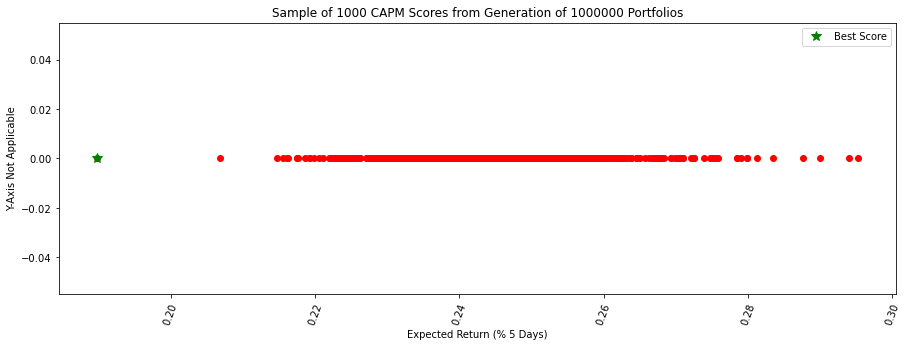

In [11]:
#Portfolio returns visualization

#Must be less than num_hypothetical_portfolios - 1
num_data_points = 1000
frequency = "5 Days"
scaler = 100 * numperiods

#Indexes for Sample of CAPM scores
index_for_graph = np.random.randint(0, (num_hypothetical_portfolios - 1), num_data_points)

#Initialize list with best score
capm_examples = [best_score * scaler]

#Grab 'num_data_points' data points to graph
for d in range(num_data_points):
    capm_examples.append(capm_scores[index_for_graph[d]] * scaler)

#We have 1d data, so all y values are 0
y_values = [0] * (num_data_points + 1)

# Plot the data, pinpoint best score
plt.scatter(capm_examples, y_values, color = 'r')
plt.plot(best_score * scaler, 0, marker = '*', color = 'g', ls = 'none', ms = 10, label = 'Best Score')

# Set axis and title
plt.title(f'Sample of {num_data_points} CAPM Scores from Generation of {num_hypothetical_portfolios} Portfolios')
plt.xlabel(f'Expected Return (% {frequency})')
plt.xticks(rotation = '70')
plt.ylabel('Y-Axis Not Applicable')

#Change size of graph
plt.gcf().set_size_inches(15, 5)

plt.legend(loc = 'best')

plt.show()

Below we can test how the actual returns of our portfolio in a given time period compare to the expected return, as well as the market return.

We are using the market as a benchmark because it is the representation of systematic risk. If we can outperform systematic risk, we consider our portfolio a success.

In [12]:
#Performance check

#Consumes weights, dataframe of prices, capital, start and end date, returns weekly returns of the portfolio
def performance_check(weights, ticker_list, capital, start_set, end_set):
    starting = capital
    ending = []
    returns_port = []
    #Ticker objects
    ticker_set = [yf.Ticker(ticker) for ticker in ticker_list]   

    #Adds returns
    for i in range (0, len(start_set)): 
        values = []

        #Start value of day x is close value of day x - 1
        if i > 0:
            starting = ending[i - 1]

        for t in range(len(ticker_set)):
            #For history dataframe
            end = (str((pd.to_datetime(end_set[i]) + relativedelta(days = 1)).strftime("%Y-%m-%d")))

            #Grab Open and Close data
            ticker_data = ticker_set[t].history(start = start_set[i], end  = end)[['Open', 'Close']]

            #Shares if purchased on open of monday and sold on friday
            values.append(starting / ticker_data.loc[start_set[i], 'Open'] * ticker_data.loc[end_set[i], 'Close'])
    
        ending.append(np.dot(values, weights))

        #Percent change in value 
        returns_port.append((ending[i] - starting) / starting * 100)
        
    return(returns_port)
    
#Requires: performance_check_start_date is later than or equal to 'start', performance_check_end_date is earlier than or equal to 'end', both variables are
#valid trading days, and performance_check_start_date is earlier than performance_check_end_date
performance_check_start_date = '2022-10-31'
performance_check_end_date = '2022-11-04'
market = 'NYSE'
market_ticker = '^NYA'

#Get returns
market_return = performance_check([1], [market_ticker], capital, [performance_check_start_date], [performance_check_end_date])
port_return = performance_check(optimal_weighting, ticklist_final, capital, [performance_check_start_date], [performance_check_end_date])

#Summary
print(f"Return of portfolio from {performance_check_start_date} to {performance_check_end_date}: {np.round(port_return[0], 2)}%.")
print(f"Expected return for time period \"{frequency}\" for reference: {np.round(port_expected_return, 2)}%.")
print(f"Return of market \"{market}\" during this time period for reference: {np.round(market_return[0], 2)}%.")

Return of portfolio from 2022-10-31 to 2022-11-04: -0.36%.
Expected return for time period "5 Days" for reference: 0.19%.
Return of market "NYSE" during this time period for reference: -0.63%.


Below is an expanded version of the above performance check, and can be used to view the returns of the portfolio, the returns of the market, the average return of both, and the expected return of the portfolio over a time period. We use this information to confirm our hypothesis. Specifically, the graph that is produced by this function should have 4 main characteristics:

1. The average return of the portfolio (red line) should be close to the expected return of the portfolio (red dotted line)
2. The average and expected return of the portfolio should be closer to 0 (blue dotted / dashed line) than the market average return (green line)
3. The average distance from 0% return of our portfolio should be smaller than that of the market
4. There should be a greater percentage of data points from the returns of our portfolio closer to 0 than from the returns of the market.

If all of these characteristics are present, we consider the portfolio a success, as this would indicate we have made a good prediction of expected return, and beat the market in terms of our goal(our benchmark).

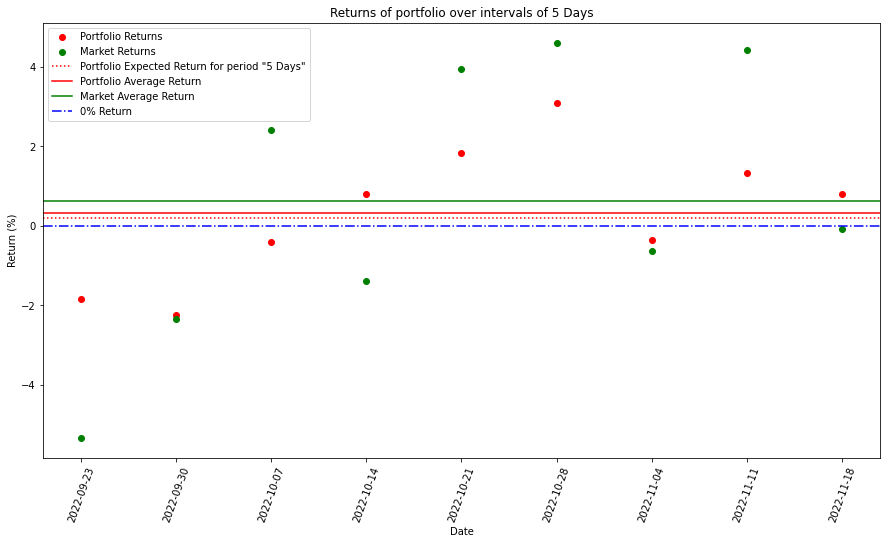

Average distance from 0% return; portfolio: 1.41%
Average distance from 0% return; NYSE: 2.8%

% of weekly returns in portfolio closer to 0 than NYSE: 88.89%

Standard deviation of portfolio returns: 1.62%


In [13]:
#Sanity check #2
#    Note: Here we compare our data points to an estimated 4 day return of the portfolio since we use closing prices (Monday close to
#          Friday close is 4 trading days). Numbers will always be compared to numperiods - 1.
#    Note: API requests can be super inconsistent. This cell took 1m when run on our computers, so theres nothing we can do if it takes longer on yours.

startD_strt = '2022-09-19'#Must be a Monday
endD_strt = '2022-09-23'#Must be a Friday
weeksPerPeriod = 1

start_dSet = [startD_strt]
end_dSet = [endD_strt]

#We want 9 periods
num_periods = 9

#Add (num_periods - 1) subsequent (weeksPerPeriod) weeks to start and end sets
for i in range (0, num_periods - 1):
    start_dSet.append(str((pd.to_datetime(start_dSet[i]) + relativedelta(days = weeksPerPeriod * 7)).strftime("%Y-%m-%d")))
    end_dSet.append(str((pd.to_datetime(end_dSet[i]) + relativedelta(days = weeksPerPeriod * 7)).strftime("%Y-%m-%d")))

#start_dSet.replace()If there is a monday in your start date set which is a holiday, replace it with the tuesday here
#end_dSet.replace()If there is a friday in your end date set which is a holiday, replace it with thursday here

#For comparison
market = 'NYSE'
market_ticker = '^NYA'

#Get returns
market_returns = performance_check([1], [market_ticker], capital, start_dSet, end_dSet)
returns = performance_check(optimal_weighting, tickersPrice_final, capital, start_dSet, end_dSet)

# Plot the data, set reference lines for portfolio expected return, actual return, market return
plt.scatter(end_dSet, returns, color = 'r', label = 'Portfolio Returns')
plt.scatter(end_dSet, market_returns, color = 'g', label = 'Market Returns')
plt.axhline(y = port_expected_return, color = 'r', linestyle = ':', label = f'Portfolio Expected Return for period \"{frequency}\"')
plt.axhline(y = np.mean(returns), color = 'r', linestyle = '-', label = 'Portfolio Average Return')
plt.axhline(y = np.mean(market_returns), color = 'g', linestyle = '-', label = 'Market Average Return')
plt.axhline(y = 0, color = 'b', linestyle = '-.', label = '0% Return')


# Set axis and title
plt.title(f'Returns of portfolio over intervals of {frequency}')
plt.xlabel(f'Date')
plt.xticks(rotation = '70')
plt.ylabel(f'Return (%)')

plt.legend(loc = 'best')

#Change size of graph
plt.gcf().set_size_inches(15, 8)

plt.show()

#Grab average distance from 0 of data points
returns_abs = [abs(x) for x in returns]
market_returns_abs = [abs(x) for x in market_returns]
returnsADF0 = np.round(np.mean(returns_abs), 2)
market_returnsADF0 = np.round(np.mean(market_returns_abs), 2)

closer = 0

#Calculating amount of times our portfolio is closer to 0% return than the market
for i in range(0, len(returns_abs)):
    if returns_abs[i] < market_returns_abs[i]:
        closer += 1

closer = np.round(closer / len(returns_abs) * 100, 2)

#Dataframe to store the final portfolio's and the market stock's percent returns
portfolio_market_stock_pr_df = pd.DataFrame({"Portfolio": returns, "Market Stock": market_returns})
#Beta Calculations of the final portfolio and the market stock
market_stock_var = portfolio_market_stock_pr_df["Market Stock"].var()
final_portfolio_beta_matrix = portfolio_market_stock_pr_df.cov()/market_stock_var
final_portfolio_beta = final_portfolio_beta_matrix.iloc[0,1]

#Conclusion
print(f"Average distance from 0% return; portfolio: {returnsADF0}%")
print(f"Average distance from 0% return; {market}: {market_returnsADF0}%")
print(f"\n% of weekly returns in portfolio closer to 0 than {market}: {closer}%")
print(f"\nStandard deviation of portfolio returns: {np.round(np.std(returns), 2)}%")

In [14]:
#Final dataframe, output to csv
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv("Stocks_Group_05.csv", encoding='utf-8')
#Final portfolio is below concusion and sources, as per assignment information 

### Conclusion

Our goal was to take in a list of stocks and generate a portfolio that will yield a short-term return as close to 0 as possible. We first cleaned up our data to ensure each ticker we would use represented a stock who met certain criteria. Then, we chose the least volatile stocks to use to generate hypothetical portfolios. We generated one million hypothetical portfolios, and used a modified Capital Asset Pricing Model to obtain the portfolio whose expected return was the closest to zero. Finally, we performed some data analysis, and explained why the portfolio that our code generated is optimal for achieving our goal.

There were many ways to create a portfolio which would fulfill our goals, but we hypothesize that our method (apart from noted drawbacks) is the most efficient and accurate.

### Sources
- *Weight Generation: https://stackoverflow.com/questions/74527506/creating-a-list-of-n-numbers-between-x-and-y-who-sum-up-to-z
- Code and concepts: Notes of Professor James Thompson
- Capital Asset Pricing Model: https://www.investopedia.com/terms/c/capm.asp#toc-the-capm-and-the-efficient-frontier

In [15]:
#Final portfolio
Portfolio_Final

,Ticker,Price,Shares,Value,Weight
1,ABBV,157.110001,77.490752,12174.572045,0.024349
2,ABT,103.879997,190.945723,19835.441215,0.039671
3,BMY,78.959999,167.159840,13198.940827,0.026398
4,CL,76.919998,210.808903,16215.420422,0.032431
5,COST,523.369995,33.002464,17272.499335,0.034545
6,CSCO,47.619999,294.434198,14020.956173,0.028042
7,CVS,97.889999,106.128635,10388.932025,0.020778
8,KMI,18.280001,852.331262,15580.616049,0.031161
9,KO,62.080002,172.018679,10678.919899,0.021358
10,LLY,361.170013,59.718748,21568.620968,0.043137


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Piero Camposeo, Sathun Suthakaran, Ishaan Bansal